# Generate a music using RNN

## Setup

We use the [`pretty_midi`](https://github.com/craffel/pretty-midi) library to create and parse MIDI files, and [`pyfluidsynth`](https://github.com/nwhitehead/pyfluidsynth) for generating audio playback in Colab.

In [ ]:
!sudo apt install -y fluidsynth

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fluidsynth is already the newest version (2.2.5-1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [ ]:
!pip install --upgrade pyfluidsynth

In [ ]:
!pip install --upgrade pyfluidsynth

In [ ]:
!pip install pretty_midi

In [ ]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Optional

Here is a brief description of each of these libraries and what they are typically used for:

### Standard Libraries

* collections:

Provides specialized container datatypes like namedtuple, deque, Counter, OrderedDict, and defaultdict.
Example use: Counting occurrences of items in a list using Counter.

* datetime:

Supplies classes for manipulating dates and times.
Example use: Getting the current date and time with datetime.datetime.now().

* glob:

Finds all the pathnames matching a specified pattern according to the rules used by the Unix shell.
Example use: Listing all .txt files in a directory with glob.glob('*.txt').

* pathlib:

Offers classes for filesystem paths with semantics appropriate for different operating systems.
Example use: Creating a Path object for a given file path using pathlib.Path('path/to/file').

### Third-Party Libraries

* fluidsynth:

A real-time software synthesizer based on the SoundFont 2 specifications.
Example use: Playing MIDI files using soundfonts for more realistic sound reproduction.

* numpy:

A fundamental package for numerical computing in Python, providing support for arrays, matrices, and a large collection of mathematical functions.
Example use: Creating an array with numpy.array([1, 2, 3]).

* pandas:

A powerful data manipulation and analysis library that provides data structures like DataFrame and Series.
Example use: Reading a CSV file into a DataFrame with pandas.read_csv('file.csv').

* pretty_midi:

A library for working with MIDI data, providing functionality for manipulating MIDI files and extracting information.
Example use: Loading a MIDI file with pretty_midi.PrettyMIDI('file.mid').

* seaborn:

A data visualization library based on matplotlib that provides a high-level interface for drawing attractive statistical graphics.
Example use: Creating a scatter plot with seaborn.scatterplot(data=df, x='x', y='y').

*tensorflow:

An open-source library for numerical computation and large-scale machine learning.
Example use: Building and training neural networks for various tasks like image recognition and natural language processing.

* IPython Display
* IPython.display:
Contains utilities for displaying rich media (like images, videos, and audio) within IPython notebooks.
Example use: Displaying an image in a Jupyter notebook with IPython.display.Image('image.png').

* Matplotlib
* matplotlib.pyplot:
A state-based interface to the Matplotlib library for creating static, animated, and interactive visualizations in Python.
Example use: Plotting a line graph with plt.plot(x, y).

* Typing
* typing:
Provides runtime support for type hints, enabling better code readability and type checking.
Example use: Specifying a function parameter type with def foo(bar: Optional[int]).

These libraries cover a wide range of functionalities, from data manipulation and visualization to machine learning and real-time audio synthesis.

In [ ]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

### Sampling rate:
 The number of samples of audio carried per second. In digital audio, this determines the quality and resolution of the audio signal.

* Higher sampling rates provide better audio quality but require more storage and processing power.

* Common sampling rates include 8 kHz (telephone quality), 44.1 kHz (CD quality), and 48 kHz (professional audio quality).

By setting _SAMPLING_RATE to 16,000:

* The audio signal will be sampled 16,000 times per second.

* This rate is commonly used in speech processing and some music applications because it balances audio quality and computational efficiency.

## Download the Maestro dataset

* Purpose: This code snippet ensures that the MAESTRO v2.0.0 dataset is available in the specified directory. If the directory does not exist, it downloads and extracts the dataset from a specified URL.

* Usage: This is useful for machine learning tasks involving MIDI data, such as training models for music generation or analysis.

The MAESTRO dataset is a commonly used dataset in the field of music information retrieval, containing MIDI and corresponding audio files of classical piano music.

In [ ]:
data_dir = pathlib.Path('data/maestro-v2.0.0')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

The dataset contains about 1,200 MIDI files.

* Purpose: This code snippet searches for all MIDI files within the data/maestro-v2.0.0 directory (recursively) and prints the total number of such files.

* Usage: This is useful for verifying that the dataset has been properly downloaded and extracted, and for understanding the size of the dataset you will be working with.

In [ ]:
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 1282


## Process a MIDI file
First, use pretty_midi to parse a single MIDI file and inspect the format of the notes.

In [ ]:
sample_file = filenames[1]
print(sample_file)

data/maestro-v2.0.0/2015/MIDI-Unprocessed_R2_D1-2-3-6-7-8-11_mid--AUDIO-from_mp3_03_R2_2015_wav--1.midi


Generate a `PrettyMIDI` object for the sample MIDI file.

In [ ]:
pm = pretty_midi.PrettyMIDI(sample_file)

Play the sample file.

* Purpose: This function generates a short audio clip from a given MIDI file and creates an audio widget for playback in a Jupyter notebook.

* Usage: Useful for quickly listening to a portion of a MIDI file to verify its content or quality without playing the entire file

In [ ]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [ ]:
display_audio(pm)

Do some inspection on the MIDI file. What kinds of instruments are used?

In [ ]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Acoustic Grand Piano


## Extract notes

* Purpose: This code snippet extracts and prints information (pitch, note name, duration) about the first 10 notes of a specified instrument in a MIDI file.

* Usage: Useful for inspecting the properties of notes in a MIDI file, which can be helpful for debugging, analysis, or understanding the structure of the MIDI data.

In [ ]:
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=74, note_name=D5, duration=0.0323
1: pitch=74, note_name=D5, duration=0.0437
2: pitch=78, note_name=F#5, duration=0.0698
3: pitch=74, note_name=D5, duration=0.0427
4: pitch=71, note_name=B4, duration=0.0396
5: pitch=71, note_name=B4, duration=0.0646
6: pitch=74, note_name=D5, duration=0.0604
7: pitch=71, note_name=B4, duration=0.0385
8: pitch=66, note_name=F#4, duration=0.2333
9: pitch=70, note_name=A#4, duration=0.1010


We will use three variables to represent a note when training the model: `pitch`, `step` and `duration`. The pitch is the perceptual quality of the sound as a MIDI note number.
The `step` is the time elapsed from the previous note or start of the track.
The `duration` is how long the note will be playing in seconds and is the difference between the note end and note start times.

Extract the notes from the sample MIDI file.

In [ ]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [ ]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,74,1.055208,1.087500,0.000000,0.032292
1,74,1.193750,1.237500,0.138542,0.043750
2,78,1.263542,1.333333,0.069792,0.069792
3,74,1.351042,1.393750,0.087500,0.042708
4,71,1.457292,1.496875,0.106250,0.039583


It may be easier to interpret the note names rather than the pitches, so we can use the function below to convert from the numeric pitch values to note names. The note name shows the type of note, accidental and octave number (e.g. C#4).

In [ ]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['D5', 'D5', 'F#5', 'D5', 'B4', 'B4', 'D5', 'B4', 'F#4', 'F#3'],
      dtype='<U3')

To visualize the musical piece, plot the note pitch, start and end across the length of the track (i.e. piano roll). Start with the first 100 notes

In [ ]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

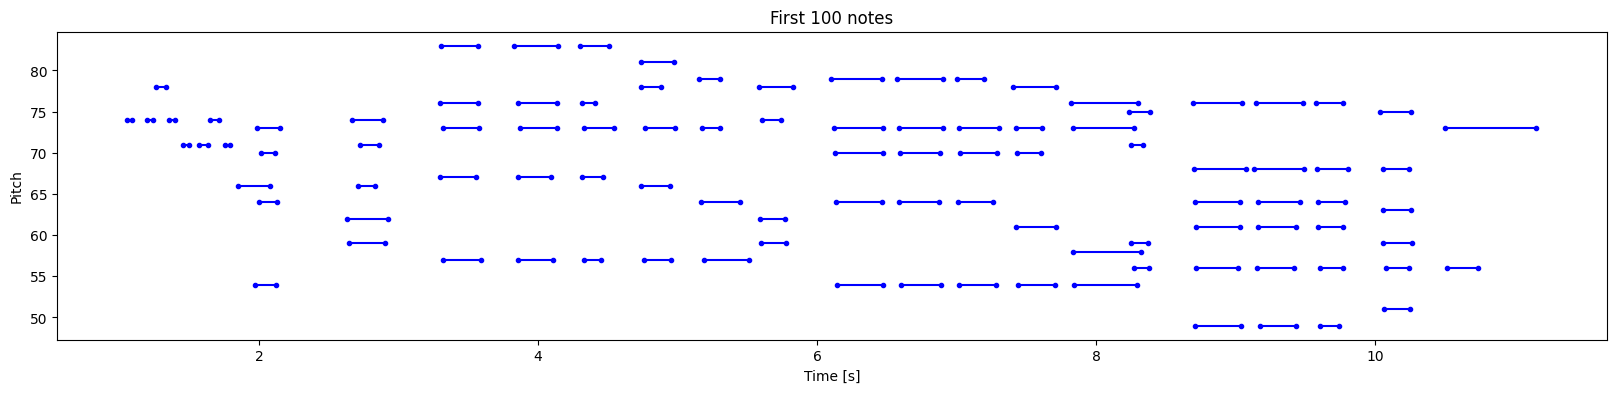

In [ ]:
plot_piano_roll(raw_notes, count=100)

Plot the notes for the entire track.

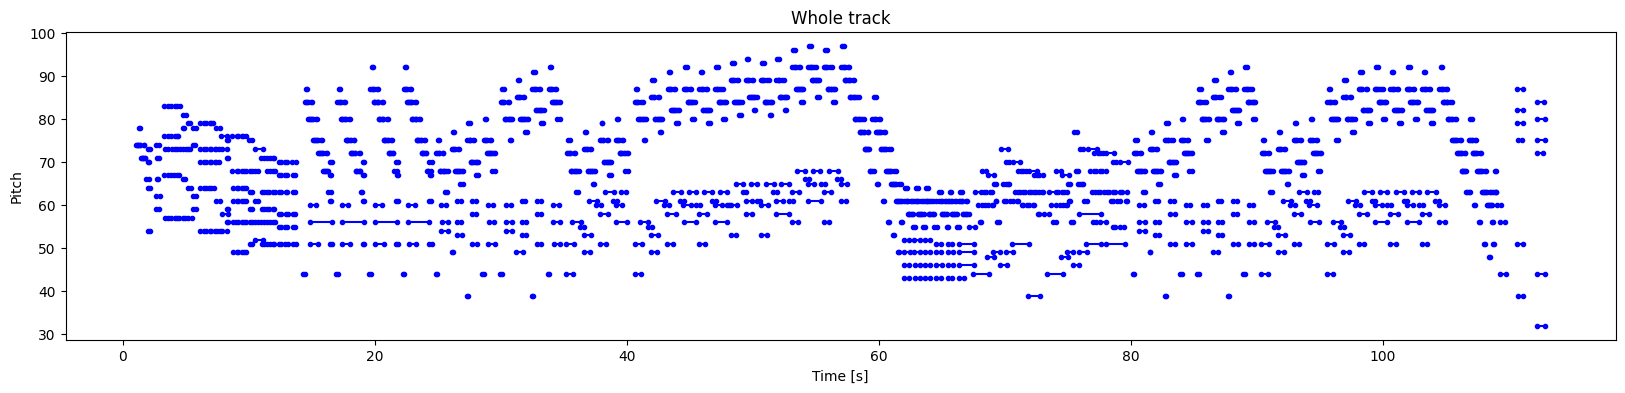

In [ ]:
plot_piano_roll(raw_notes)

Check the distribution of each note variable.

In [ ]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

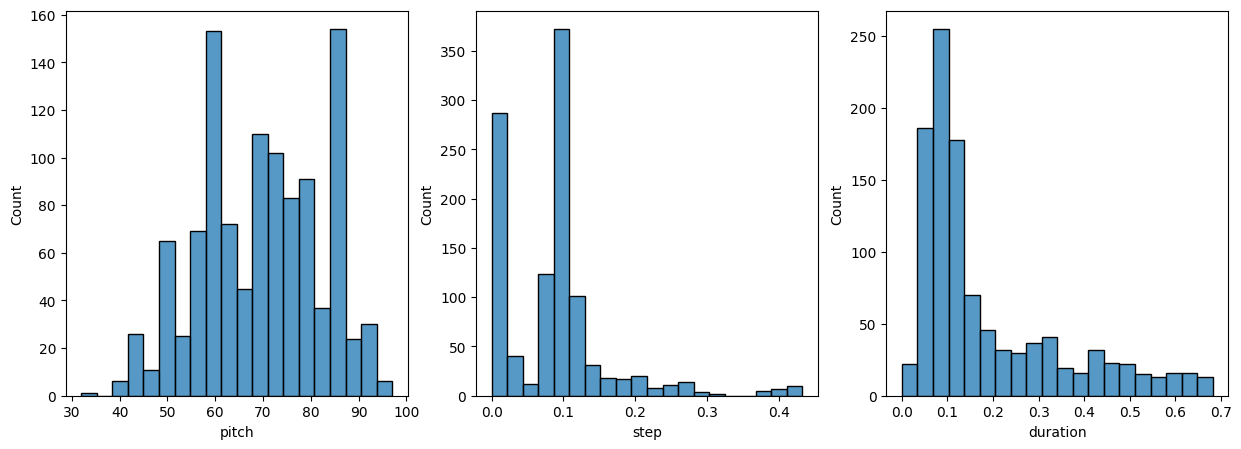

In [ ]:
plot_distributions(raw_notes)

## Create a MIDI file

We can generate your own MIDI file from a list of notes using the function below.

In [ ]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str,
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [ ]:
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

Play the generated MIDI file and see if there is any difference.

In [ ]:
display_audio(example_pm)

Create the training dataset by extracting notes from the MIDI files. You can start by using a small number of files, and experiment later with more. This may take a couple minutes.

In [ ]:
num_files = 5
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [ ]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 14058


Next, create a `tf.data.Dataset` from the parsed notes.

In [ ]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [ ]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

We will train the model on batches of sequences of notes. Each example will consist of a sequence of notes as the input features, and the next note as the label. In this way, the model will be trained to predict the next note in a sequence.

In [ ]:
def create_sequences(
    dataset: tf.data.Dataset,
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

Set the sequence length for each example. Experiment with different lengths (e.g. 50, 100, 150) to see which one works best for the data, or use [hyperparameter tuning](https://www.tensorflow.org/tutorials/keras/keras_tuner). The size of the vocabulary (`vocab_size`) is set to 128 representing all the pitches supported by `pretty_midi`.

In [ ]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

The shape of the dataset is (100,1), meaning that the model will take 100 notes as input, and learn to predict the following note as output.

In [ ]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (25, 3)
sequence elements (first 10): tf.Tensor(
[[0.375      0.         0.05729167]
 [0.28125    0.00625    1.92083333]
 [0.375      0.15416667 1.721875  ]
 [0.4296875  0.084375   0.10625   ]
 [0.46875    0.07083333 0.08333333]
 [0.5        0.075      0.03645833]
 [0.46875    0.096875   0.06666667]
 [0.5234375  0.08125    0.10520833]
 [0.5625     0.07291667 0.08125   ]
 [0.59375    0.08125    0.025     ]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=72.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.07916666666666661>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.12187500000000018>}


Batch the examples, and configure the dataset for performance.

The train_ds dataset undergoes several transformations to prepare it for efficient training:

* Shuffling: Randomizes the order of elements in the dataset.

* Batching: Groups elements into batches of the specified size.

* Caching: Stores the dataset in memory to avoid recomputation and speed up training.

* Prefetching: Ensures that the next batch is ready while the current one is being processed, reducing idle time.
This setup optimizes the data pipeline for training machine learning models, making the training process faster and more efficient.

In [ ]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [ ]:
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

The model will have three outputs, one for each note variable. For `step` and `duration`, you will use a custom loss function based on mean squared error that encourages the model to output non-negative values.

In [ ]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [ ]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 25, 3)]              0         []                            
                                                                                                  
 lstm_2 (LSTM)               (None, 128)                  67584     ['input_3[0][0]']             
                                                                                                  
 duration (Dense)            (None, 1)                    129       ['lstm_2[0][0]']              
                                                                                                  
 pitch (Dense)               (None, 128)                  16512     ['lstm_2[0][0]']              
                                                                                            

Testing the `model.evaluate` function, we can see that the `pitch` loss is significantly greater than the `step` and `duration` losses.
Note that `loss` is the total loss computed by summing all the other losses and is currently dominated by the `pitch` loss.

In [ ]:
losses = model.evaluate(train_ds, return_dict=True)
losses

219/219 [==============================] - 7s 8ms/step - loss: 5.5249 - duration_loss: 0.4076 - pitch_loss: 4.8553 - step_loss: 0.2620


{'loss': 5.524933338165283,
 'duration_loss': 0.4076438844203949,
 'pitch_loss': 4.855323791503906,
 'step_loss': 0.26196715235710144}

One way balance this is to use the `loss_weights` argument to compile:

In [ ]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

The `loss` then becomes the weighted sum of the individual losses.

In [ ]:
model.evaluate(train_ds, return_dict=True)

219/219 [==============================] - 3s 5ms/step - loss: 0.9124 - duration_loss: 0.4076 - pitch_loss: 4.8553 - step_loss: 0.2620


{'loss': 0.9123774766921997,
 'duration_loss': 0.4076438844203949,
 'pitch_loss': 4.855323791503906,
 'step_loss': 0.26196715235710144}

Train the model.

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [ ]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50
219/219 [==============================] - 8s 9ms/step - loss: 0.3049 - duration_loss: 0.0685 - pitch_loss: 4.2899 - step_loss: 0.0219
Epoch 2/50
219/219 [==============================] - 3s 13ms/step - loss: 0.2847 - duration_loss: 0.0612 - pitch_loss: 4.0965 - step_loss: 0.0186
Epoch 3/50
219/219 [==============================] - 1s 5ms/step - loss: 0.2808 - duration_loss: 0.0596 - pitch_loss: 4.0559 - step_loss: 0.0183
Epoch 4/50
219/219 [==============================] - 1s 5ms/step - loss: 0.2759 - duration_loss: 0.0576 - pitch_loss: 3.9865 - step_loss: 0.0190
Epoch 5/50
219/219 [==============================] - 1s 5ms/step - loss: 0.2717 - duration_loss: 0.0569 - pitch_loss: 3.9233 - step_loss: 0.0187
Epoch 6/50
219/219 [==============================] - 1s 5ms/step - loss: 0.2665 - duration_loss: 0.0544 - pitch_loss: 3.8729 - step_loss: 0.0185
Epoch 7/50
219/219 [==============================] - 1s 5ms/step - loss: 0.2651 - duration_loss: 0.0543 - pitch_loss: 3.85

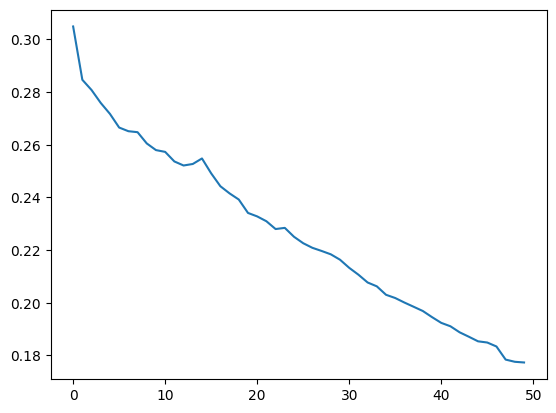

In [ ]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

## Generate notes

function below generates one note from a sequence of notes.

For note pitch, it draws a sample from the softmax distribution of notes produced by the model, and does not simply pick the note with the highest probability. Always picking the note with the highest probability would lead to repetitive sequences of notes being generated.

The temperature parameter can be used to control the randomness of notes generated.

In [ ]:
def predict_next_note(
    notes: np.ndarray,
    model: tf.keras.Model,
    temperature: float = 1.0) -> tuple[int, float, float]:
  """Generates a note as a tuple of (pitch, step, duration), using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

Now generate some notes. We can play around with temperature and the starting sequence in `next_notes` and see what happens.

In [ ]:
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

1/1 [==============================] - 0s 18ms/step


In [ ]:
generated_notes.head(10)

,pitch,step,duration,start,end
0,47,0.090004,0.228995,0.090004,0.318999
1,80,0.024998,0.083834,0.115002,0.198835
2,80,0.008137,0.075168,0.123138,0.198306
3,97,0.002600,0.083549,0.125738,0.209288
4,80,0.002693,0.083639,0.128432,0.212071
5,101,0.008709,0.083112,0.137140,0.220252
6,50,0.013253,0.096020,0.150393,0.246412
7,95,0.009714,0.107832,0.160107,0.267939
8,101,0.009571,0.105274,0.169678,0.274951
9,94,0.006773,0.090043,0.176450,0.266493


In [ ]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

Visualize the generated notes.

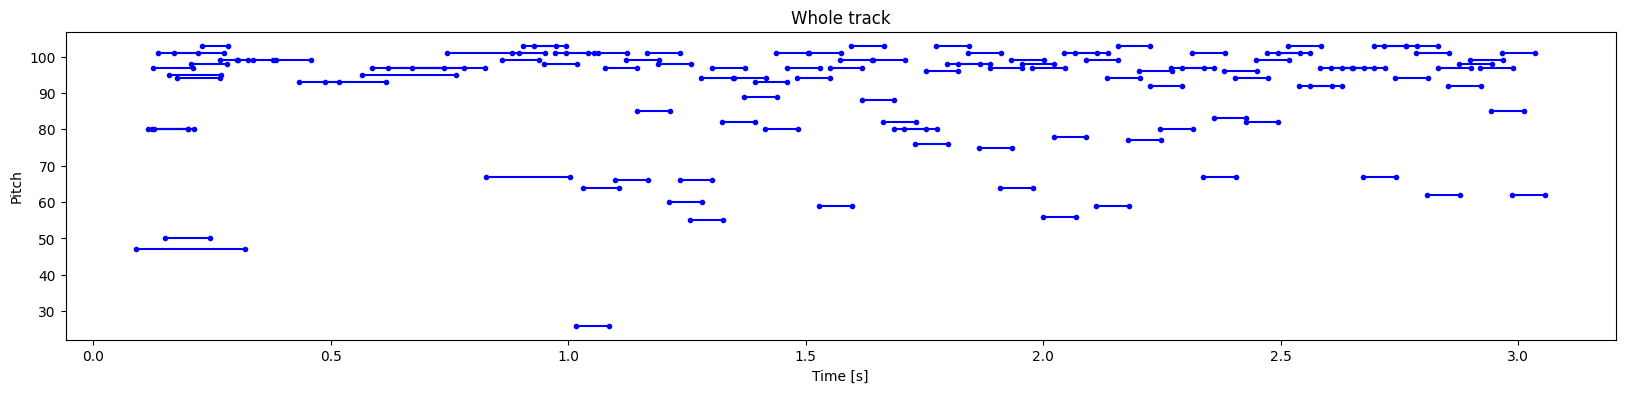

In [ ]:
plot_piano_roll(generated_notes)

Check the distributions of pitch, step and duration.

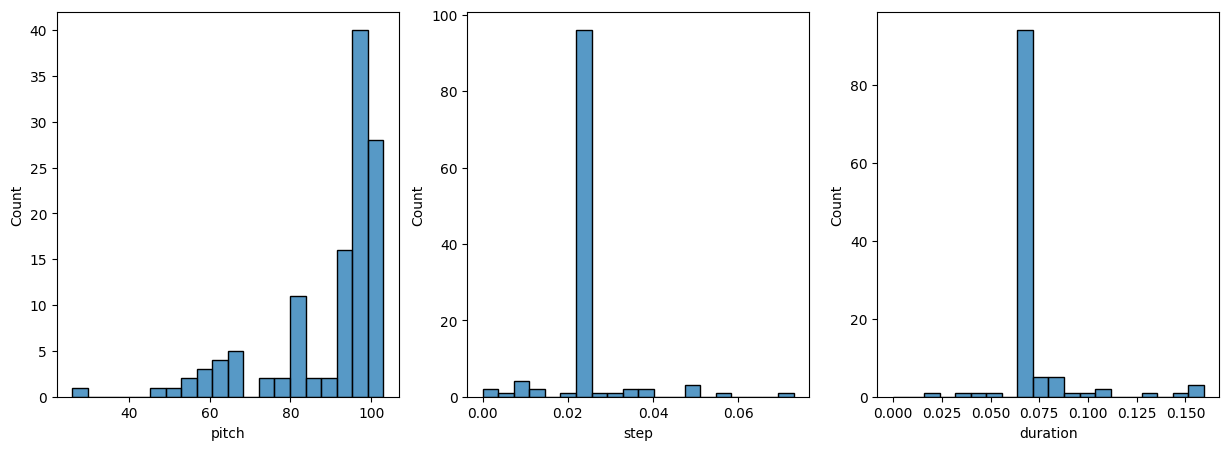

In [ ]:
plot_distributions(generated_notes)

In [ ]:
from google.colab import files
files.download(out_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In the above plots, we will notice the change in distribution of the note variables.
Since there is a feedback loop between the model's outputs and inputs, the model tends to generate similar sequences of outputs to reduce the loss.
This is particularly relevant for `step` and `duration`, which uses the MSE loss.
For `pitch`, we can increase the randomness by increasing the `temperature` in `predict_next_note`.
